In [386]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from scipy import stats
from scipy.stats import boxcox
import scipy.optimize as spo

import probscale

import shapely
from shapely.geometry import MultiPoint, Point, Polygon

In [191]:
ciclovias_df = gpd.read_file("data/ciclovias-zip-05082019/ciclovias.shp")

In [192]:
ciclovias_df.shape

(2932, 28)

In [193]:
len(ciclovias_df['id'].unique())

2917

In [194]:
ciclovias_df = ciclovias_df.loc[ciclovias_df.duplicated('id') == False]
ciclovias_df.shape

(2917, 28)

In [195]:
ciclovias_df.head()

,id,codigo,nomoficial,alt_izqini,alt_izqfin,alt_derini,alt_derfin,nomanter,nom_mapa,tipo_c,...,tooltip_bi,red_jerarq,red_tp,COMUNA,COM_PAR,COM_IMPAR,BARRIO,BARRIO_PAR,BARRIO_IMP,geometry
0,896,16003,"OBLIGADO RAFAEL, Av.Costanera",6182,6200,6181,6199,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,...,Ciclovía,VÍA DISTRIBUIDORA PRINCIPAL,None,13,13,13,PALERMO,PALERMO,PALERMO,LINESTRING (103128.1074910719 108699.191765290...
1,1724,16003,"OBLIGADO RAFAEL, Av.Costanera",4202,4500,4201,4499,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,...,Ciclovía,VÍA DISTRIBUIDORA PRINCIPAL,None,14,14,14,PALERMO,PALERMO,PALERMO,LINESTRING (104784.0365070056 107940.241396083...
2,1828,16003,"OBLIGADO RAFAEL, Av.Costanera",3452,4200,3451,4199,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,...,Ciclovía,VÍA DISTRIBUIDORA PRINCIPAL,None,14,14,14,PALERMO,PALERMO,PALERMO,LINESTRING (104911.6935667442 107817.874904555...
3,1997,21059,TRONADOR,0,0,0,0,ESTOMBA Y PLAZA,TRONADOR,CALLE,...,Ciclovía,VÍA LOCAL,None,12,12,12,COGHLAN,COGHLAN,COGHLAN,LINESTRING (98376.11090415106 107631.000347565...
4,4846,20075,SARMIENTO AV.,2602,3100,2601,3099,None,AV. SARMIENTO,AVENIDA,...,Ciclovía,VÍA DISTRIBUIDORA PRINCIPAL,None,14,14,14,PALERMO,PALERMO,PALERMO,LINESTRING (103918.9643071062 105376.802938277...


In [8]:
ciclovias_df.columns

Index(['id', 'codigo', 'nomoficial', 'alt_izqini', 'alt_izqfin', 'alt_derini',
       'alt_derfin', 'nomanter', 'nom_mapa', 'tipo_c', 'long', 'sentido',
       'cod_sent', 'observa', 'bicisenda', 'lado_ciclo', 'recorrid_x',
       'ciclo_obse', 'tooltip_bi', 'red_jerarq', 'red_tp', 'COMUNA', 'COM_PAR',
       'COM_IMPAR', 'BARRIO', 'BARRIO_PAR', 'BARRIO_IMP', 'geometry'],
      dtype='object')

In [9]:
ciclovias_df.iloc[0]

id                                                          896
codigo                                                    16003
nomoficial                        OBLIGADO RAFAEL, Av.Costanera
alt_izqini                                                 6182
alt_izqfin                                                 6200
alt_derini                                                 6181
alt_derfin                                                 6199
nomanter                                   COSTANERA NORTE, Av.
nom_mapa                           AV.COSTANERA RAFAEL OBLIGADO
tipo_c                                                  AVENIDA
long                                                      56.38
sentido                                                   DOBLE
cod_sent                                                      2
observa                                                    None
bicisenda                                             Ciclovías
lado_ciclo                              

In [196]:
# Keep only columns we are going to use for size + simplicity
ciclovias_df = ciclovias_df[['id','nomanter','nom_mapa','tipo_c','sentido','bicisenda','red_jerarq','COMUNA','BARRIO','geometry']]

In [197]:
ciclovias_df.head()

,id,nomanter,nom_mapa,tipo_c,sentido,bicisenda,red_jerarq,COMUNA,BARRIO,geometry
0,896,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,DOBLE,Ciclovías,VÍA DISTRIBUIDORA PRINCIPAL,13,PALERMO,LINESTRING (103128.1074910719 108699.191765290...
1,1724,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,DOBLE,Ciclovías,VÍA DISTRIBUIDORA PRINCIPAL,14,PALERMO,LINESTRING (104784.0365070056 107940.241396083...
2,1828,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,DOBLE,Ciclovías,VÍA DISTRIBUIDORA PRINCIPAL,14,PALERMO,LINESTRING (104911.6935667442 107817.874904555...
3,1997,ESTOMBA Y PLAZA,TRONADOR,CALLE,DOBLE,Ciclovías,VÍA LOCAL,12,COGHLAN,LINESTRING (98376.11090415106 107631.000347565...
4,4846,None,AV. SARMIENTO,AVENIDA,DOBLE,Ciclovías,VÍA DISTRIBUIDORA PRINCIPAL,14,PALERMO,LINESTRING (103918.9643071062 105376.802938277...


In [18]:
ciclovias_df.groupby('sentido')['sentido'].count()

sentido
-                16
CRECIENTE      1393
DECRECIENTE    1263
DOBLE           236
PEATONAL         24
Name: sentido, dtype: int64

In [32]:
ciclovias_df['tipo_c'].unique()

array(['AVENIDA', 'CALLE', 'BOULEVARD', 'SENDERO', 'TÚNEL', 'PASAJE',
       'PUENTE'], dtype=object)

In [34]:
ciclovias_df.groupby('tipo_c')['tipo_c'].count()

tipo_c
AVENIDA       658
BOULEVARD       8
CALLE        2229
PASAJE          4
PUENTE          4
SENDERO        28
TÚNEL           1
Name: tipo_c, dtype: int64

In [43]:
metrobus_df = gpd.read_file("data/recorrido-de-metrobus-zip/recorrido_de_metrobus.shp")

In [45]:
colectivos_df = gpd.read_file("data/recorrido-colectivos-zip/recorridos_de_colectivos.shp")

In [46]:
metrobus_df.crs

{'proj': 'tmerc',
 'lat_0': -34.6297166,
 'lon_0': -58.4627,
 'k': 0.999998,
 'x_0': 100000,
 'y_0': 100000,
 'ellps': 'intl',
 'units': 'm',
 'no_defs': True}

In [47]:
colectivos_df.crs

{'proj': 'tmerc',
 'lat_0': -34.6297166,
 'lon_0': -58.4627,
 'k': 0.999998,
 'x_0': 100000,
 'y_0': 100000,
 'ellps': 'intl',
 'units': 'm',
 'no_defs': True}

In [54]:
colectivos_df = colectivos_df[['id','descriptio','geometry']]

In [198]:
## Create buffer for cycle lanes to intersect with bus route.
# I'm keeping the buffer at 30m like when we intersected trees.
ciclovias_with_buffer = ciclovias_df.copy()
ciclovias_with_buffer['geometry'] = ciclovias_with_buffer.geometry.buffer(30)

In [55]:
# Also create buffer for bus network so we can intersect polygon with polygon
colectivos_with_buffer = colectivos_df.copy()
colectivos_with_buffer['geometry'] = colectivos_with_buffer.geometry.buffer(5)

In [65]:
# Intersect sample segment with bus network
sample_segment = ciclovias_with_buffer.iloc[[1]]
intersecting_buses = gpd.overlay(sample_segment, colectivos_with_buffer, how="intersection")
intersecting_buses.head()

,id_1,nomanter,nom_mapa,tipo_c,sentido,bicisenda,red_jerarq,COMUNA,BARRIO,id_2,descriptio,geometry
0,1724,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,DOBLE,Ciclovías,VÍA DISTRIBUIDORA PRINCIPAL,14,PALERMO,8417,160 ramal C (vuelta)-Comun Básico,"POLYGON ((104517.8349336015 108130.0779375967,..."
1,1724,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,DOBLE,Ciclovías,VÍA DISTRIBUIDORA PRINCIPAL,14,PALERMO,8462,160 ramal D (vuelta)-Comun Básico,"POLYGON ((104517.8349336015 108130.0779375967,..."
2,1724,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,DOBLE,Ciclovías,VÍA DISTRIBUIDORA PRINCIPAL,14,PALERMO,8468,160 ramal D (ida)-Comun Básico,"POLYGON ((104517.8349336015 108130.0779375967,..."
3,1724,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,DOBLE,Ciclovías,VÍA DISTRIBUIDORA PRINCIPAL,14,PALERMO,8467,160 ramal C (ida)-Comun Básico,"POLYGON ((104517.8349336015 108130.0779375967,..."
4,1724,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,DOBLE,Ciclovías,VÍA DISTRIBUIDORA PRINCIPAL,14,PALERMO,9097,33 ramal C (ida)-Comun Básico,"POLYGON ((104517.8349336015 108130.0779375967,..."


In [67]:
ciclovias_with_buffer.head()

,id,nomanter,nom_mapa,tipo_c,sentido,bicisenda,red_jerarq,COMUNA,BARRIO,geometry,num_buses
0,896,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,DOBLE,Ciclovías,VÍA DISTRIBUIDORA PRINCIPAL,13,PALERMO,"POLYGON ((103065.5325559756 108711.9755039961,...",25
1,1724,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,DOBLE,Ciclovías,VÍA DISTRIBUIDORA PRINCIPAL,14,PALERMO,"POLYGON ((104679.3407381174 107988.8753784508,...",25
2,1828,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,DOBLE,Ciclovías,VÍA DISTRIBUIDORA PRINCIPAL,14,PALERMO,"POLYGON ((104816.8656363114 107867.640978357, ...",25
3,1997,ESTOMBA Y PLAZA,TRONADOR,CALLE,DOBLE,Ciclovías,VÍA LOCAL,12,COGHLAN,"POLYGON ((98345.46846434861 107623.9656324848,...",0
4,4846,None,AV. SARMIENTO,AVENIDA,DOBLE,Ciclovías,VÍA DISTRIBUIDORA PRINCIPAL,14,PALERMO,"POLYGON ((104199.9384944202 105777.4862796715,...",129


In [199]:
ciclovias_with_buffer['num_buses'] = 0

def calculate_buses(row):
    row_df = gpd.GeoDataFrame(geometry=[row['geometry']])
    intersecting_buses = gpd.overlay(row_df, colectivos_with_buffer, how="intersection")
    
    return intersecting_buses.shape[0]

ciclovias_with_buffer['num_buses'] = ciclovias_with_buffer.apply(lambda x: calculate_buses(x),axis=1)

/anaconda3/envs/geopandas-env/lib/python3.7/site-packages/geopandas/base.py:35: UserWarning: GeoSeries crs mismatch: None and {'proj': 'tmerc', 'lat_0': -34.6297166, 'lon_0': -58.4627, 'k': 0.999998, 'x_0': 100000, 'y_0': 100000, 'ellps': 'intl', 'units': 'm', 'no_defs': True}
  right.crs))


In [200]:
ciclovias_with_buffer.sort_values('num_buses', ascending=False).head()

,id,nomanter,nom_mapa,tipo_c,sentido,bicisenda,red_jerarq,COMUNA,BARRIO,geometry,num_buses
1219,27686,None,CALZADA CIRCULAR PLAZA ITALIA,AVENIDA,CRECIENTE,Ciclovías,VÍA LOCAL,14,PALERMO,"POLYGON ((103913.2483352741 105289.8569547233,...",223
2678,4361,17 DE OCTUBRE - ALMEYRA - ARANA,AV.INT.BULLRICH,AVENIDA,DOBLE,Ciclovías,VÍA DISTRIBUIDORA PRINCIPAL,14,PALERMO,"POLYGON ((103519.0781228553 105998.2584672679,...",198
2313,16343,GARAY - BRASIL,AV. JUAN DE GARAY,AVENIDA,CRECIENTE,Ciclovías,VÍA DISTRIBUIDORA PRINCIPAL,1,CONSTITUCION,"POLYGON ((107443.3271802311 100227.2374744316,...",197
1267,4464,None,AV. SANTA FE,AVENIDA,DOBLE,Ciclovías Proyectadas,VÍA DISTRIBUIDORA PRINCIPAL,14,PALERMO,"POLYGON ((103414.375292815 105624.859376226, 1...",191
1638,4653,None,GODOY CRUZ,CALLE,CRECIENTE,Ciclovías,VÍA DISTRIBUIDORA COMPLEMENTARIA,14,PALERMO,"POLYGON ((103449.5087024379 105608.5117092677,...",187


In [69]:
ciclovias_with_buffer.to_file("data/ciclovias-with-num-buses")

In [70]:
# Also create buffer for metrobus network so we can intersect polygon with polygon
metrobus_with_buffer = metrobus_df.copy()
metrobus_with_buffer['geometry'] = metrobus_with_buffer.geometry.buffer(5)

In [201]:
ciclovias_with_buffer['is_metro'] = False

def is_metrobus(row):
    row_df = gpd.GeoDataFrame(geometry=[row['geometry']])
    intersecting_metrobus = gpd.overlay(row_df, metrobus_with_buffer, how="intersection")
    
    if intersecting_metrobus.shape[0] > 0:
        return True
    return False

ciclovias_with_buffer['is_metro'] = ciclovias_with_buffer.apply(lambda x: is_metrobus(x),axis=1)

In [77]:
ciclovias_with_buffer.sort_values(['is_metro','num_buses'], ascending=False).head()

,id,nomanter,nom_mapa,tipo_c,sentido,bicisenda,red_jerarq,COMUNA,BARRIO,geometry,num_buses,is_metro
2678,4361,17 DE OCTUBRE - ALMEYRA - ARANA,AV.INT.BULLRICH,AVENIDA,DOBLE,Ciclovías,VÍA DISTRIBUIDORA PRINCIPAL,14,PALERMO,"POLYGON ((103519.0781228553 105998.2584672679,...",198,True
2313,16343,GARAY - BRASIL,AV. JUAN DE GARAY,AVENIDA,CRECIENTE,Ciclovías,VÍA DISTRIBUIDORA PRINCIPAL,1,CONSTITUCION,"POLYGON ((107443.3271802311 100227.2374744316,...",197,True
1267,4464,None,AV. SANTA FE,AVENIDA,DOBLE,Ciclovías Proyectadas,VÍA DISTRIBUIDORA PRINCIPAL,14,PALERMO,"POLYGON ((103414.375292815 105624.859376226, 1...",191,True
1638,4653,None,GODOY CRUZ,CALLE,CRECIENTE,Ciclovías,VÍA DISTRIBUIDORA COMPLEMENTARIA,14,PALERMO,"POLYGON ((103449.5087024379 105608.5117092677,...",187,True
2314,16344,None,LIMA,CALLE,DOBLE,Ciclovías,VÍA LOCAL,1,CONSTITUCION,"POLYGON ((107464.473248831 100303.117720432, 1...",187,True


In [76]:
ciclovias_with_buffer.loc[ciclovias_with_buffer['is_metro'] == True].shape

(190, 12)

In [57]:
ciclovias_df.groupby('bicisenda')['bicisenda'].count()

bicisenda
Bicisendas                    62
Bicisendas preexistentes      71
Carriles Preferenciales      220
Ciclovías                   2055
Ciclovías Proyectadas        462
Ciclovías en obra              4
Ciclovías mano única          48
Interrumpida por Obras        10
Name: bicisenda, dtype: int64

In [61]:
ciclovias_df.loc[ciclovias_df['bicisenda'] == 'Bicisendas'].head()
# These look horrible - turns out "bicisenda" means no separation from traffic

,id,nomanter,nom_mapa,tipo_c,sentido,bicisenda,red_jerarq,COMUNA,BARRIO,geometry
5,7367,ESTOMBA Y PLAZA,TRONADOR,CALLE,DOBLE,Bicisendas,VÍA LOCAL,15,PATERNAL,LINESTRING (98987.70876672903 104100.499898008...
7,27809,LA VIA DEL TRANVIA REAL,GUTENBERG,CALLE,DOBLE,Bicisendas,VÍA LOCAL,15,PATERNAL,LINESTRING (99363.76184284221 104112.170598523...
111,2183,None,ROGELIO YRURTIA,CALLE,DECRECIENTE,Bicisendas,VÍA LOCAL,12,SAAVEDRA,LINESTRING (96356.97787733123 107519.240900575...
120,2308,None,ROGELIO YRURTIA,CALLE,DECRECIENTE,Bicisendas,VÍA LOCAL,12,SAAVEDRA,LINESTRING (96387.9301775257 107438.7663534038...
125,2419,None,ROGELIO YRURTIA,CALLE,DECRECIENTE,Bicisendas,VÍA LOCAL,12,SAAVEDRA,LINESTRING (96354.71416565019 107213.865025016...


In [64]:
ciclovias_df.loc[ciclovias_df['bicisenda'] == 'Carriles Preferenciales'].head(5)

,id,nomanter,nom_mapa,tipo_c,sentido,bicisenda,red_jerarq,COMUNA,BARRIO,geometry
346,7005,TRIUNVIRATO (parcial),AV. CORRIENTES,AVENIDA,DECRECIENTE,Carriles Preferenciales,VÍA DISTRIBUIDORA PRINCIPAL,15,CHACARITA,LINESTRING (101334.8029843214 104287.984694102...
373,7586,TRIUNVIRATO (parcial),AV. CORRIENTES,AVENIDA,DECRECIENTE,Carriles Preferenciales,VÍA DISTRIBUIDORA PRINCIPAL,15,VILLA CRESPO,LINESTRING (101603.3559710423 103984.251026082...
382,7683,TRIUNVIRATO (parcial),AV. CORRIENTES,AVENIDA,DECRECIENTE,Carriles Preferenciales,VÍA DISTRIBUIDORA PRINCIPAL,15,VILLA CRESPO,LINESTRING (101671.494178203 103907.8625474247...
394,7831,TRIUNVIRATO (parcial),AV. CORRIENTES,AVENIDA,DECRECIENTE,Carriles Preferenciales,VÍA DISTRIBUIDORA PRINCIPAL,15,VILLA CRESPO,LINESTRING (101742.8197730895 103827.755422548...
406,7969,TRIUNVIRATO (parcial),AV. CORRIENTES,AVENIDA,DECRECIENTE,Carriles Preferenciales,VÍA DISTRIBUIDORA PRINCIPAL,15,VILLA CRESPO,LINESTRING (101812.7079190548 103749.242002860...


In [85]:
ciclovias_df.loc[ciclovias_df['sentido'] == "PEATONAL"].shape

(24, 10)

In [84]:
ciclovias_df.loc[ciclovias_df['tipo_c'] == "SENDERO"].shape

(28, 10)

In [89]:
ciclovias_df.loc[ciclovias_df['tipo_c'] == "BOULEVARD"].head()

,id,nomanter,nom_mapa,tipo_c,sentido,bicisenda,red_jerarq,COMUNA,BARRIO,geometry
769,13838,None,ROSARIO VERA PEÑALOZA,BOULEVARD,DECRECIENTE,Ciclovías,VÍA DISTRIBUIDORA COMPLEMENTARIA,1,PUERTO MADERO,LINESTRING (109172.2142048932 101264.255572027...
1308,13715,None,ROSARIO VERA PEÑALOZA,BOULEVARD,DECRECIENTE,Ciclovías,VÍA DISTRIBUIDORA COMPLEMENTARIA,1,PUERTO MADERO,LINESTRING (109390.8560561769 101310.233367860...
1309,13769,None,ROSARIO VERA PEÑALOZA,BOULEVARD,DECRECIENTE,Ciclovías,VÍA DISTRIBUIDORA COMPLEMENTARIA,1,PUERTO MADERO,LINESTRING (109209.2153790215 101293.029553404...
1310,13886,None,ROSARIO VERA PEÑALOZA,BOULEVARD,DOBLE,Ciclovías,VÍA DISTRIBUIDORA COMPLEMENTARIA,1,PUERTO MADERO,LINESTRING (108946.5939589433 101239.044846008...
1311,13920,None,ROSARIO VERA PEÑALOZA,BOULEVARD,CRECIENTE,Ciclovías Proyectadas,VÍA DISTRIBUIDORA COMPLEMENTARIA,1,PUERTO MADERO,LINESTRING (108881.5889240492 101232.825850701...


In [202]:
def calculate_separation_category(row):
    street_type = row['tipo_c']
    lane_type = row['bicisenda']
    lane_direction = row['sentido']
    
    if lane_type == 'Carriles Preferenciales':
        return 0
    elif street_type in ['SENDERO','BOULEVARD'] or lane_direction == 'PEATONAL':
        return 3
    elif lane_type in ['Bicisendas','Bicisendas preexistentes']:
        return 1
    elif lane_type in [
        'Ciclovías',
        'Ciclovías Proyectadas',
        'Ciclovías en obra',
        'Interrumpida por Obras',
        'Ciclovías mano única'
    ]:
        return 2
    else:
        return -1

ciclovias_with_buffer['sep_traffic'] = ciclovias_with_buffer.apply(lambda x: calculate_separation_category(x),axis=1)

In [203]:
ciclovias_with_buffer.loc[ciclovias_with_buffer['sep_traffic'] == -1].shape

(0, 13)

In [204]:
ciclovias_with_buffer.head()

,id,nomanter,nom_mapa,tipo_c,sentido,bicisenda,red_jerarq,COMUNA,BARRIO,geometry,num_buses,is_metro,sep_traffic
0,896,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,DOBLE,Ciclovías,VÍA DISTRIBUIDORA PRINCIPAL,13,PALERMO,"POLYGON ((103065.5325559756 108711.9755039961,...",25,False,2
1,1724,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,DOBLE,Ciclovías,VÍA DISTRIBUIDORA PRINCIPAL,14,PALERMO,"POLYGON ((104679.3407381174 107988.8753784508,...",25,False,2
2,1828,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,DOBLE,Ciclovías,VÍA DISTRIBUIDORA PRINCIPAL,14,PALERMO,"POLYGON ((104816.8656363114 107867.640978357, ...",25,False,2
3,1997,ESTOMBA Y PLAZA,TRONADOR,CALLE,DOBLE,Ciclovías,VÍA LOCAL,12,COGHLAN,"POLYGON ((98345.46846434861 107623.9656324848,...",0,False,2
4,4846,None,AV. SARMIENTO,AVENIDA,DOBLE,Ciclovías,VÍA DISTRIBUIDORA PRINCIPAL,14,PALERMO,"POLYGON ((104199.9384944202 105777.4862796715,...",129,False,2


In [183]:
ciclovias_with_green_shade_noise = gpd.read_file("data/merge_trees_parks_noise_shade_250819/merge_trees_parks_noise_shade_250819.shp")

In [184]:
ciclovias_with_green_shade_noise.head()

,id,codigo,nomoficial,alt_izqini,alt_izqfin,alt_derini,alt_derfin,nomanter,nom_mapa,tipo_c,...,COM_IMPAR,BARRIO,BARRIO_PAR,BARRIO_IMP,num_trees,sum_height,per_park,mean_noise,shade_win,geometry
0,896,16003,"OBLIGADO RAFAEL, Av.Costanera",6182,6200,6181,6199,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,...,13,PALERMO,PALERMO,PALERMO,17,162,7.028699,76.5,0.0,LINESTRING (103128.1074910719 108699.191765290...
1,1724,16003,"OBLIGADO RAFAEL, Av.Costanera",4202,4500,4201,4499,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,...,14,PALERMO,PALERMO,PALERMO,44,468,0.155443,77.5,0.0,LINESTRING (104784.0365070056 107940.241396083...
2,1828,16003,"OBLIGADO RAFAEL, Av.Costanera",3452,4200,3451,4199,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,...,14,PALERMO,PALERMO,PALERMO,21,229,0.629245,75.0,0.0,LINESTRING (104911.6935667442 107817.874904555...
3,1997,21059,TRONADOR,0,0,0,0,ESTOMBA Y PLAZA,TRONADOR,CALLE,...,12,COGHLAN,COGHLAN,COGHLAN,17,143,0.000000,57.5,226.0,LINESTRING (98376.11090415106 107631.000347565...
4,4846,20075,SARMIENTO AV.,2602,3100,2601,3099,None,AV. SARMIENTO,AVENIDA,...,14,PALERMO,PALERMO,PALERMO,51,359,52.357627,72.5,79.8,LINESTRING (103918.9643071062 105376.802938277...


In [205]:
merge_all_indicators = ciclovias_with_green_shade_noise.merge(ciclovias_with_buffer[['id','num_buses','is_metro','sep_traffic']], on='id')
merge_all_indicators.shape

(2917, 36)

In [206]:
merge_all_indicators.head()

,id,codigo,nomoficial,alt_izqini,alt_izqfin,alt_derini,alt_derfin,nomanter,nom_mapa,tipo_c,...,BARRIO_IMP,num_trees,sum_height,per_park,mean_noise,shade_win,geometry,num_buses,is_metro,sep_traffic
0,896,16003,"OBLIGADO RAFAEL, Av.Costanera",6182,6200,6181,6199,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,...,PALERMO,17,162,7.028699,76.5,0.0,LINESTRING (103128.1074910719 108699.191765290...,25,False,2
1,1724,16003,"OBLIGADO RAFAEL, Av.Costanera",4202,4500,4201,4499,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,...,PALERMO,44,468,0.155443,77.5,0.0,LINESTRING (104784.0365070056 107940.241396083...,25,False,2
2,1828,16003,"OBLIGADO RAFAEL, Av.Costanera",3452,4200,3451,4199,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,...,PALERMO,21,229,0.629245,75.0,0.0,LINESTRING (104911.6935667442 107817.874904555...,25,False,2
3,1997,21059,TRONADOR,0,0,0,0,ESTOMBA Y PLAZA,TRONADOR,CALLE,...,COGHLAN,17,143,0.000000,57.5,226.0,LINESTRING (98376.11090415106 107631.000347565...,0,False,2
4,4846,20075,SARMIENTO AV.,2602,3100,2601,3099,None,AV. SARMIENTO,AVENIDA,...,PALERMO,51,359,52.357627,72.5,79.8,LINESTRING (103918.9643071062 105376.802938277...,129,False,2


In [207]:
merge_all_indicators.to_file("data/merge_all_indicators-250819")

## Plot the indicators distributions

### Greenery

In [209]:
trees_Q3 = merge_all_indicators['num_trees'].quantile(.75)
trees_Q1 = merge_all_indicators['num_trees'].quantile(.25)
trees_IQR = trees_Q3 - trees_Q1 
upper_tukey_fence = trees_Q3 + 1.5 * trees_IQR
upper_tukey_fence

74.5

In [244]:
merge_all_indicators['num_trees'].quantile([.25,.5,.75])

0.25    17.0
0.50    30.0
0.75    40.0
Name: num_trees, dtype: float64

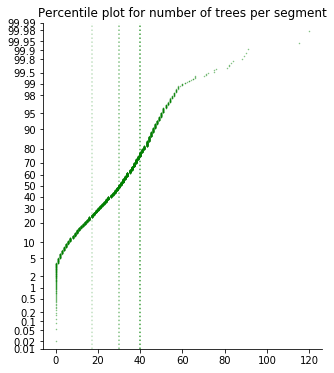

In [270]:
fig, ax = plt.subplots(1,1, figsize=(5,6))

scatter_options = dict(
    marker='.',
    linestyle='none',
    markersize=1,
    alpha=0.5,
    zorder=5,
    color='green'
)

probscale.probplot(
    merge_all_indicators['num_trees'],
    ax=ax,
    probax='y',
    scatter_kws=scatter_options
)

ax.set_title("Percentile plot for number of trees per segment")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.axvline(x=17, linestyle=":", color="green", alpha=0.25)
ax.axvline(x=30, linestyle=":", color="green", alpha=0.5)
ax.axvline(x=40, linestyle=":", color="green", alpha=0.75)

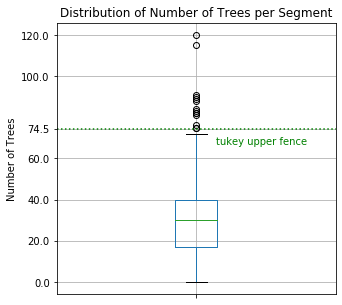

In [215]:
fig,ax = plt.subplots(1,1, figsize=(5,5))
merge_all_indicators.boxplot(ax=ax, column='num_trees')
ax.set_title("Distribution of Number of Trees per Segment")

ax.set_xticklabels([""])
ax.axhline(y=74.5, color="green", linestyle=':')
ax.annotate("tukey upper fence",xy=(1.07,67), color="green")
ax.set_ylabel("Number of Trees")
y_ticks = [0,20,40, 60, 74.5,100,120]
ax.set_yticks(y_ticks)

fig.savefig("../images/num-trees-tukey-upper-fence.png", dpi=1200, bbox_inches="tight")

In [216]:
parks_Q3 = merge_all_indicators['per_park'].quantile(.75)
parks_Q1 = merge_all_indicators['per_park'].quantile(.25)
parks_IQR = parks_Q3 - parks_Q1 
upper_tukey_fence = parks_Q3 + 1.5 * parks_IQR
upper_tukey_fence

8.796099561163443

In [281]:
# Let's set the max for parks at 50% and see what that looks like
merge_all_indicators.loc[merge_all_indicators['per_park']>50].sort_values('per_park').head()

,id,codigo,nomoficial,alt_izqini,alt_izqfin,alt_derini,alt_derfin,nomanter,nom_mapa,tipo_c,...,BARRIO_IMP,num_trees,sum_height,per_park,mean_noise,shade_win,geometry,num_buses,is_metro,sep_traffic
1369,26461,19057,"ROCA, CNEL. AV.",3802,3860,0,0,CAMINO AL PUENTE ALSINA O DE LA TABLADA,AV.CNEL. ROCA,AVENIDA,...,VILLA SOLDATI,17,124,51.277761,72.5,0.0,LINESTRING (101742.7449411328 95390.8073752811...,9,True,2
1334,3567,9016,IRAOLA AV.,0,0,0,0,None,AV. IRAOLA,AVENIDA,...,PALERMO,9,76,51.405095,67.5,10.9,LINESTRING (104273.0658943874 106260.433787147...,0,False,1
2830,29708,6025,"FIGUEROA ALCORTA, PRES. AV.",4802,5050,0,0,"CENTENARIO, Av.",AV.PRES. FIGUEROA ALCORTA,AVENIDA,...,PALERMO,8,136,51.811266,77.5,0.0,LINESTRING (104382.8202399099 106689.672925993...,8,False,2
1203,5571,6025,"FIGUEROA ALCORTA, PRES. AV.",2102,2160,2101,2159,"CENTENARIO, Av.",AV.PRES. FIGUEROA ALCORTA,AVENIDA,...,RECOLETA,14,168,52.177883,80.0,9.2,LINESTRING (106673.1284717392 104998.992430667...,18,False,2
2523,21417,8013,HERRERA,1402,1500,0,0,None,HERRERA,CALLE,...,BARRACAS,33,216,52.258688,77.5,209.4,LINESTRING (107982.6905046292 98396.3071360819...,37,False,2


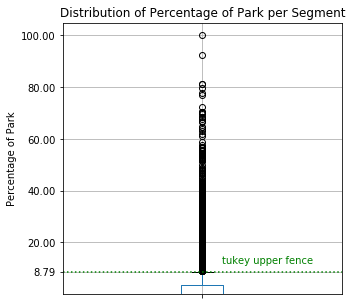

In [221]:
fig,ax = plt.subplots(1,1, figsize=(5,5))
merge_all_indicators.boxplot(ax=ax, column='per_park')
ax.set_title("Distribution of Percentage of Park per Segment")

ax.set_xticklabels([""])
ax.axhline(y=8.79, color="green", linestyle=':')
ax.annotate("tukey upper fence",xy=(1.07,12), color="green")
ax.set_ylabel("Percentage of Park")
y_ticks = [8.79,20,40, 60, 80,100]
ax.set_yticks(y_ticks)
ax.set_ylim(bottom=0)

fig.savefig("../images/perc-parks-tukey-upper-fence.png", dpi=1200, bbox_inches="tight")

Text(0.5, 0.98, 'Greenery Indicators')

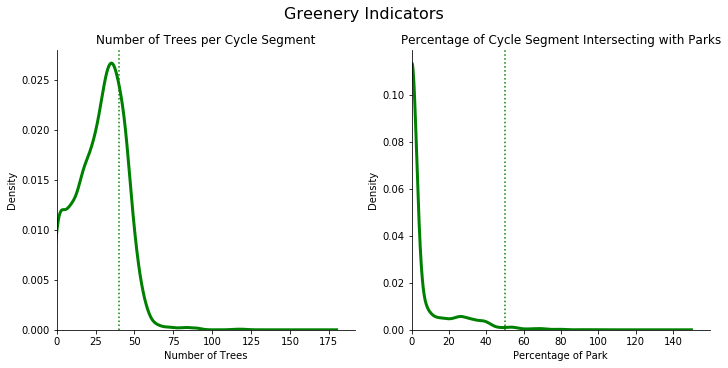

In [282]:
fig,axs = plt.subplots(1,2, figsize=(10, 5), constrained_layout=True)

merge_all_indicators['num_trees'].plot.kde(
    ax=axs[0],
    title="Number of Trees per Cycle Segment",
    color="green",
    linewidth=3
)
axs[0].set_xlabel("Number of Trees")
axs[0].set_xlim(left=0)
axs[0].set_ylim(bottom=0)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].axvline(x=40, color="green", linestyle=':')

merge_all_indicators['per_park'].plot.kde(
    ax=axs[1],
    title="Percentage of Cycle Segment Intersecting with Parks",
    color="green",
    linewidth=3
)
axs[1].set_xlabel("Percentage of Park")
axs[1].set_xlim(left=0)
axs[1].set_ylim(bottom=0)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].axvline(x=50, color="green", linestyle=':')

fig.suptitle("Greenery Indicators", fontsize=16)
# fig.savefig("../images/greenery-indicators-dist.png", dpi=900, bbox_inches="tight")

In [283]:
def normalize_trees(row):
    if row['num_trees'] > 40:
        return 1
    return row['num_trees'] / 40

merge_all_indicators['norm_trees'] = merge_all_indicators.apply(lambda x: normalize_trees(x), axis=1)
merge_all_indicators.head()

,id,codigo,nomoficial,alt_izqini,alt_izqfin,alt_derini,alt_derfin,nomanter,nom_mapa,tipo_c,...,num_trees,sum_height,per_park,mean_noise,shade_win,geometry,num_buses,is_metro,sep_traffic,norm_trees
0,896,16003,"OBLIGADO RAFAEL, Av.Costanera",6182,6200,6181,6199,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,...,17,162,7.028699,76.5,0.0,LINESTRING (103128.1074910719 108699.191765290...,25,False,2,0.425
1,1724,16003,"OBLIGADO RAFAEL, Av.Costanera",4202,4500,4201,4499,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,...,44,468,0.155443,77.5,0.0,LINESTRING (104784.0365070056 107940.241396083...,25,False,2,1.000
2,1828,16003,"OBLIGADO RAFAEL, Av.Costanera",3452,4200,3451,4199,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,...,21,229,0.629245,75.0,0.0,LINESTRING (104911.6935667442 107817.874904555...,25,False,2,0.525
3,1997,21059,TRONADOR,0,0,0,0,ESTOMBA Y PLAZA,TRONADOR,CALLE,...,17,143,0.000000,57.5,226.0,LINESTRING (98376.11090415106 107631.000347565...,0,False,2,0.425
4,4846,20075,SARMIENTO AV.,2602,3100,2601,3099,None,AV. SARMIENTO,AVENIDA,...,51,359,52.357627,72.5,79.8,LINESTRING (103918.9643071062 105376.802938277...,129,False,2,1.000


In [328]:
def normalize_parks(row):
    if row['per_park'] > 50:
        return 1
    return row['per_park'] / 50

merge_all_indicators['norm_park'] = merge_all_indicators.apply(lambda x: normalize_parks(x), axis=1)
merge_all_indicators.head()

,id,codigo,nomoficial,alt_izqini,alt_izqfin,alt_derini,alt_derfin,nomanter,nom_mapa,tipo_c,...,sum_height,per_park,mean_noise,shade_win,geometry,num_buses,is_metro,sep_traffic,norm_trees,norm_park
0,896,16003,"OBLIGADO RAFAEL, Av.Costanera",6182,6200,6181,6199,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,...,162,7.028699,76.5,0.0,LINESTRING (103128.1074910719 108699.191765290...,25,False,2,0.425,0.140574
1,1724,16003,"OBLIGADO RAFAEL, Av.Costanera",4202,4500,4201,4499,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,...,468,0.155443,77.5,0.0,LINESTRING (104784.0365070056 107940.241396083...,25,False,2,1.000,0.003109
2,1828,16003,"OBLIGADO RAFAEL, Av.Costanera",3452,4200,3451,4199,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,...,229,0.629245,75.0,0.0,LINESTRING (104911.6935667442 107817.874904555...,25,False,2,0.525,0.012585
3,1997,21059,TRONADOR,0,0,0,0,ESTOMBA Y PLAZA,TRONADOR,CALLE,...,143,0.000000,57.5,226.0,LINESTRING (98376.11090415106 107631.000347565...,0,False,2,0.425,0.000000
4,4846,20075,SARMIENTO AV.,2602,3100,2601,3099,None,AV. SARMIENTO,AVENIDA,...,359,52.357627,72.5,79.8,LINESTRING (103918.9643071062 105376.802938277...,129,False,2,1.000,1.000000


In [329]:
merge_all_indicators.shape

(2917, 38)

In [303]:
merge_all_indicators.loc[merge_all_indicators['norm_park']>0.8].head(10)

,id,codigo,nomoficial,alt_izqini,alt_izqfin,alt_derini,alt_derfin,nomanter,nom_mapa,tipo_c,...,sum_height,per_park,mean_noise,shade_win,geometry,num_buses,is_metro,sep_traffic,norm_trees,norm_park
4,4846,20075,SARMIENTO AV.,2602,3100,2601,3099,None,AV. SARMIENTO,AVENIDA,...,359,52.357627,72.5,79.8,LINESTRING (103918.9643071062 105376.802938277...,129,False,2,1.000,1.000000
30,730,23062,VILELA,3402,3500,3401,3499,None,VILELA,CALLE,...,541,53.543495,60.0,139.1,LINESTRING (98425.52326175696 108881.737803973...,0,False,2,0.975,1.000000
34,810,23062,VILELA,3502,3600,3501,3599,None,VILELA,CALLE,...,496,55.297420,65.0,33.2,LINESTRING (98330.13687152423 108845.269317321...,2,False,2,0.900,1.000000
35,824,7028,GARCIA DEL RIO AV.,3102,3200,0,0,None,AV. GARCIA DEL RIO,AVENIDA,...,191,40.084246,67.5,202.9,LINESTRING (98813.76529000462 108785.851665925...,2,False,1,0.600,0.801685
36,825,17087,PINTO,3902,4000,3901,3999,None,PINTO,CALLE,...,146,42.807879,65.0,234.2,LINESTRING (98719.75920773169 108795.656700214...,1,False,2,0.400,0.856158
51,1043,7028,GARCIA DEL RIO,3402,3500,3401,3499,None,GARCIA DEL RIO,CALLE,...,173,40.993206,60.0,218.5,LINESTRING (98600.88471182846 108604.245158960...,0,False,2,0.575,0.819864
52,1057,17065,"PEREZ, ROQUE",3902,4000,3901,3999,URQUIZA,ROQUE PEREZ,CALLE,...,203,66.356254,67.5,234.6,LINESTRING (98394.95619372974 108552.549799903...,2,False,2,0.600,1.000000
53,1058,7028,GARCIA DEL RIO,3502,3600,3501,3599,None,GARCIA DEL RIO,CALLE,...,233,40.188052,62.5,187.6,LINESTRING (98504.81084907873 108568.042287216...,0,False,2,0.775,0.803761
56,1107,6025,"FIGUEROA ALCORTA, PRES. AV.",6502,6600,6501,6599,"CENTENARIO, Av.",AV.PRES. FIGUEROA ALCORTA,AVENIDA,...,242,41.368901,75.0,12.1,LINESTRING (102511.603331286 108510.8564510691...,21,False,2,0.675,0.827378
203,3954,3082,CASARES AV.,3502,3550,3501,3549,None,AV. CASARES,AVENIDA,...,43,56.723709,70.0,287.0,LINESTRING (105023.9969979696 105954.913962763...,4,False,2,0.125,1.000000


In [334]:
### DEA - Linear Programming optimization for each segment (we want to maximize the green score)
# We don't want to penalize if the segment has loads of trees but no parks or the other way around

# objective_function -> row['norm_trees']*x + row['norm_parks']*y
# constraints -> x+y = 1 | 0 <= x <= 1 | 0 <= y <= 1 
# coefficients need to be negative bc python tries to minimize and we want to maximize

def calculate_weights(row):
    objective_coeffs  = [-row['norm_trees'],-row['norm_park']]

    ineq_constraint_coeffs = [[row['norm_trees'],row['norm_park']]]
    ineq_constraint_consts = [1]

    eq_constraint_coeffs = [[1,1]]
    eq_constraint_consts = [1]

    x_bounds = (0.1,1)
    y_bounds = (0.1,1)

    try:
        results = spo.linprog(c=objective_coeffs, A_ub=ineq_constraint_coeffs, b_ub=ineq_constraint_consts, A_eq=eq_constraint_coeffs, b_eq=eq_constraint_consts, bounds=(x_bounds, y_bounds))

        x, y = results['x']
        P = -results['fun']
    
        if P is None or P < 0 or P == -0.0:
            P = 0
        return [round(x,2), round(y,2), round(P, 3)]
    except:
        return [-1,-1,0]


for index, row in merge_all_indicators.iterrows():
    x, y, P = calculate_weights(merge_all_indicators.iloc[index])
    merge_all_indicators.loc[merge_all_indicators['id'] == row['id'],"trees_w"] = x
    merge_all_indicators.loc[merge_all_indicators['id'] == row['id'],"park_w"] = y
    merge_all_indicators.loc[merge_all_indicators['id'] == row['id'],"green_idx"] = P
    
    

In [335]:
merge_all_indicators.head()

,id,codigo,nomoficial,alt_izqini,alt_izqfin,alt_derini,alt_derfin,nomanter,nom_mapa,tipo_c,...,shade_win,geometry,num_buses,is_metro,sep_traffic,norm_trees,norm_park,trees_w,park_w,green_idx
0,896,16003,"OBLIGADO RAFAEL, Av.Costanera",6182,6200,6181,6199,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,...,0.0,LINESTRING (103128.1074910719 108699.191765290...,25,False,2,0.425,0.140574,0.9,0.1,0.397
1,1724,16003,"OBLIGADO RAFAEL, Av.Costanera",4202,4500,4201,4499,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,...,0.0,LINESTRING (104784.0365070056 107940.241396083...,25,False,2,1.000,0.003109,0.9,0.1,0.900
2,1828,16003,"OBLIGADO RAFAEL, Av.Costanera",3452,4200,3451,4199,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,...,0.0,LINESTRING (104911.6935667442 107817.874904555...,25,False,2,0.525,0.012585,0.9,0.1,0.474
3,1997,21059,TRONADOR,0,0,0,0,ESTOMBA Y PLAZA,TRONADOR,CALLE,...,226.0,LINESTRING (98376.11090415106 107631.000347565...,0,False,2,0.425,0.000000,0.9,0.1,0.382
4,4846,20075,SARMIENTO AV.,2602,3100,2601,3099,None,AV. SARMIENTO,AVENIDA,...,79.8,LINESTRING (103918.9643071062 105376.802938277...,129,False,2,1.000,1.000000,0.5,0.5,1.000


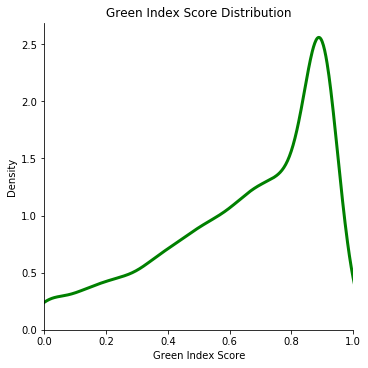

In [340]:
# Plot the distribution of the green index
fig, ax = plt.subplots(1,1, figsize=(5, 5), constrained_layout=True)

merge_all_indicators['green_idx'].plot.kde(
    ax=ax,
    title="Green Index Score Distribution",
    color="green",
    linewidth=3
)
ax.set_xlabel("Green Index Score")
ax.set_xlim(left=0,right=1)
ax.set_ylim(bottom=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

### Air Quality

In [103]:
sep_traffic_groups = merge_all_indicators.groupby('sep_traffic')['sep_traffic'].count()
sep_traffic_groups

sep_traffic
0     220
1     126
2    2537
3      49
Name: sep_traffic, dtype: int64

In [137]:
metrobus_groups = merge_all_indicators.loc[merge_all_indicators['num_buses'] > 0].groupby('is_metro')['is_metro'].count()
metrobus_groups

is_metro
False    2120
True      190
Name: is_metro, dtype: int64

In [148]:
buses_Q3 = merge_all_indicators['num_buses'].quantile(.75)
buses_Q1 = merge_all_indicators['num_buses'].quantile(.25)
buses_IQR = buses_Q3 - buses_Q1 
upper_tukey_fence = buses_Q3 + 1.5 * buses_IQR
upper_tukey_fence

48.5

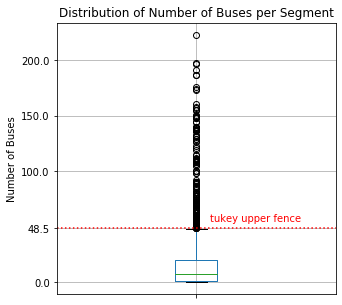

In [176]:
fig,ax = plt.subplots(1,1, figsize=(5,5))
merge_all_indicators.boxplot(ax=ax, column='num_buses')
ax.set_title("Distribution of Number of Buses per Segment")

ax.set_xticklabels([""])
ax.axhline(y=48.5, color="red", linestyle=':')
ax.annotate("tukey upper fence",xy=(1.05,55), color="red")
ax.set_ylabel("Number of Buses")
y_ticks = [0,48.5,100,150,200]
ax.set_yticks(y_ticks)

fig.savefig("../images/num-buses-tukey-upper-fence.png", dpi=1200, bbox_inches="tight")

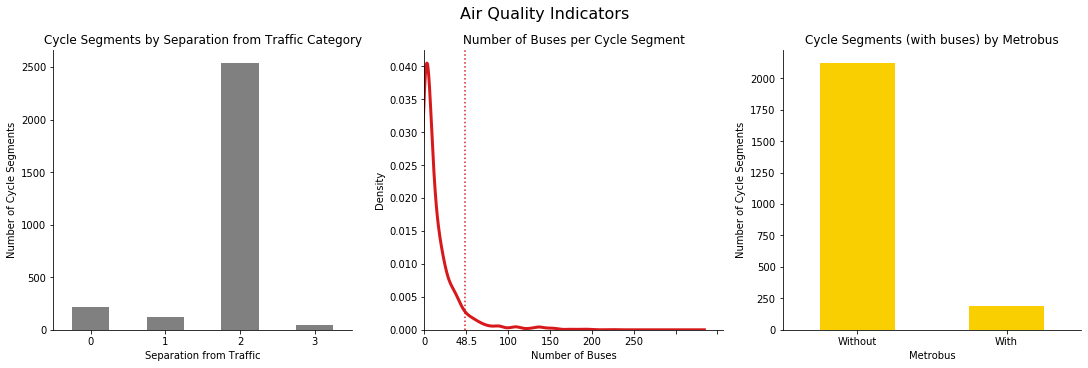

In [220]:
fig,axs = plt.subplots(1,3, figsize=(15, 5), constrained_layout=True)

sep_traffic_groups.plot.bar(
    ax=axs[0],
    title="Cycle Segments by Separation from Traffic Category",
    color="grey"
)
axs[0].set_xlabel("Separation from Traffic")
axs[0].set_ylabel("Number of Cycle Segments")
axs[0].tick_params(axis='x', labelrotation=0)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

merge_all_indicators['num_buses'].plot.kde(
    ax=axs[1],
    title="Number of Buses per Cycle Segment",
    color="#d7191c",
    linewidth=3
)
axs[1].set_xlabel("Number of Buses")
axs[1].set_xlim(left=0)
axs[1].set_ylim(bottom=0)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].axvline(x=48.5, color="#d7191c", linestyle=':')
axs[1].set_xticklabels([0,48.5,100,150,200,250])

metrobus_groups.plot.bar(
    ax=axs[2],
    title="Cycle Segments (with buses) by Metrobus",
    color="#facf01"
)
axs[2].set_xlabel("Metrobus")
axs[2].set_ylabel("Number of Cycle Segments")
axs[2].set_xticklabels(['Without','With'])
axs[2].tick_params(axis='x', labelrotation=0)
axs[2].set_ylim(bottom=0)
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)

fig.suptitle("Air Quality Indicators", fontsize=16)
fig.savefig("../images/air-quality-indicators-dist.png", dpi=900, bbox_inches="tight")

In [341]:
# Modify number of buses to reflect if they are metrobus (arbitrary reduction of 50% because they move to an inner lane)
# (Also known as Bus Rapid Transit (BRT))

def adjust_buses(row):
    if row['is_metro']:
        return row['num_buses'] * 0.5
    return row['num_buses']

merge_all_indicators['adjusted_num_buses'] = merge_all_indicators.apply(lambda x: adjust_buses(x), axis=1)


In [343]:
merge_all_indicators.loc[merge_all_indicators['is_metro']==True].head()

,id,codigo,nomoficial,alt_izqini,alt_izqfin,alt_derini,alt_derfin,nomanter,nom_mapa,tipo_c,...,geometry,num_buses,is_metro,sep_traffic,norm_trees,norm_park,trees_w,park_w,green_idx,adjusted_num_buses
26,637,7028,GARCIA DEL RIO AV.,2402,2500,0,0,None,AV. GARCIA DEL RIO,AVENIDA,...,LINESTRING (99521.81258063558 108955.562946644...,90,True,1,0.675,0.603571,0.9,0.1,0.668,45.0
71,1468,3156,CONGRESO,2302,2400,2301,2399,None,CONGRESO,CALLE,...,LINESTRING (100178.4843960352 108254.223431147...,98,True,2,0.850,0.000000,0.9,0.1,0.765,49.0
116,2267,5007,ECHEVERRIA,2352,2400,2351,2399,None,ECHEVERRIA,CALLE,...,LINESTRING (100736.6535005681 107392.136995151...,81,True,2,0.500,0.138900,0.9,0.1,0.464,40.5
164,3114,7033,"GARCIA, TEODORO",2302,2400,2301,2399,ESTECO,TEODORO GARCIA,CALLE,...,LINESTRING (101730.162183519 106774.4538380135...,66,True,2,1.000,0.000000,0.9,0.1,0.900,33.0
173,3328,7033,"GARCIA, TEODORO",2402,2500,2401,2499,ESTECO,TEODORO GARCIA,CALLE,...,LINESTRING (101614.4101366283 106624.800308008...,66,True,2,1.000,0.000000,0.9,0.1,0.900,33.0


In [344]:
def normalize_sep_traffic(row):
    if row['sep_traffic'] == 0:
        return 0
    elif row['sep_traffic'] == 1:
        return 0.33
    elif row['sep_traffic'] == 2:
        return 0.66
    else:
        return 1

merge_all_indicators['norm_sep_traffic'] = merge_all_indicators.apply(lambda x: normalize_sep_traffic(x), axis=1)

In [345]:
merge_all_indicators.head()

,id,codigo,nomoficial,alt_izqini,alt_izqfin,alt_derini,alt_derfin,nomanter,nom_mapa,tipo_c,...,num_buses,is_metro,sep_traffic,norm_trees,norm_park,trees_w,park_w,green_idx,adjusted_num_buses,norm_sep_traffic
0,896,16003,"OBLIGADO RAFAEL, Av.Costanera",6182,6200,6181,6199,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,...,25,False,2,0.425,0.140574,0.9,0.1,0.397,25.0,0.66
1,1724,16003,"OBLIGADO RAFAEL, Av.Costanera",4202,4500,4201,4499,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,...,25,False,2,1.000,0.003109,0.9,0.1,0.900,25.0,0.66
2,1828,16003,"OBLIGADO RAFAEL, Av.Costanera",3452,4200,3451,4199,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,...,25,False,2,0.525,0.012585,0.9,0.1,0.474,25.0,0.66
3,1997,21059,TRONADOR,0,0,0,0,ESTOMBA Y PLAZA,TRONADOR,CALLE,...,0,False,2,0.425,0.000000,0.9,0.1,0.382,0.0,0.66
4,4846,20075,SARMIENTO AV.,2602,3100,2601,3099,None,AV. SARMIENTO,AVENIDA,...,129,False,2,1.000,1.000000,0.5,0.5,1.000,129.0,0.66


In [346]:
# Defining 50 as the max for bus traffic (rounding up tukey fence)
# Inverting because the higher the buses, the worse the air quality is
def normalize_buses(row):
    if row['adjusted_num_buses'] > 50:
        return 0
    return 1 - (row['adjusted_num_buses'] / 50)

merge_all_indicators['norm_buses'] = merge_all_indicators.apply(lambda x: normalize_buses(x), axis=1)
merge_all_indicators.head()

,id,codigo,nomoficial,alt_izqini,alt_izqfin,alt_derini,alt_derfin,nomanter,nom_mapa,tipo_c,...,is_metro,sep_traffic,norm_trees,norm_park,trees_w,park_w,green_idx,adjusted_num_buses,norm_sep_traffic,norm_buses
0,896,16003,"OBLIGADO RAFAEL, Av.Costanera",6182,6200,6181,6199,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,...,False,2,0.425,0.140574,0.9,0.1,0.397,25.0,0.66,0.5
1,1724,16003,"OBLIGADO RAFAEL, Av.Costanera",4202,4500,4201,4499,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,...,False,2,1.000,0.003109,0.9,0.1,0.900,25.0,0.66,0.5
2,1828,16003,"OBLIGADO RAFAEL, Av.Costanera",3452,4200,3451,4199,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,...,False,2,0.525,0.012585,0.9,0.1,0.474,25.0,0.66,0.5
3,1997,21059,TRONADOR,0,0,0,0,ESTOMBA Y PLAZA,TRONADOR,CALLE,...,False,2,0.425,0.000000,0.9,0.1,0.382,0.0,0.66,1.0
4,4846,20075,SARMIENTO AV.,2602,3100,2601,3099,None,AV. SARMIENTO,AVENIDA,...,False,2,1.000,1.000000,0.5,0.5,1.000,129.0,0.66,0.0


In [368]:
# Weighted Aggregation for Air Quality - Weighing trees lower because even though they have a positive impact they don't completely overturn the air quality
def aggregate_air_quality(row):
    return row['norm_trees'] * 0.2 + row['norm_sep_traffic'] * 0.4 + row['norm_buses'] * 0.4

merge_all_indicators['air_quality_idx'] = merge_all_indicators.apply(lambda x: aggregate_air_quality(x), axis=1)
merge_all_indicators.head()

,id,codigo,nomoficial,alt_izqini,alt_izqfin,alt_derini,alt_derfin,nomanter,nom_mapa,tipo_c,...,norm_trees,norm_park,trees_w,park_w,green_idx,adjusted_num_buses,norm_sep_traffic,norm_buses,air_quality_idx,norm_noise
0,896,16003,"OBLIGADO RAFAEL, Av.Costanera",6182,6200,6181,6199,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,...,0.425,0.140574,0.9,0.1,0.397,25.0,0.66,0.5,0.549,0.800000
1,1724,16003,"OBLIGADO RAFAEL, Av.Costanera",4202,4500,4201,4499,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,...,1.000,0.003109,0.9,0.1,0.900,25.0,0.66,0.5,0.664,0.833333
2,1828,16003,"OBLIGADO RAFAEL, Av.Costanera",3452,4200,3451,4199,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,...,0.525,0.012585,0.9,0.1,0.474,25.0,0.66,0.5,0.569,0.750000
3,1997,21059,TRONADOR,0,0,0,0,ESTOMBA Y PLAZA,TRONADOR,CALLE,...,0.425,0.000000,0.9,0.1,0.382,0.0,0.66,1.0,0.749,0.166667
4,4846,20075,SARMIENTO AV.,2602,3100,2601,3099,None,AV. SARMIENTO,AVENIDA,...,1.000,1.000000,0.5,0.5,1.000,129.0,0.66,0.0,0.464,0.666667


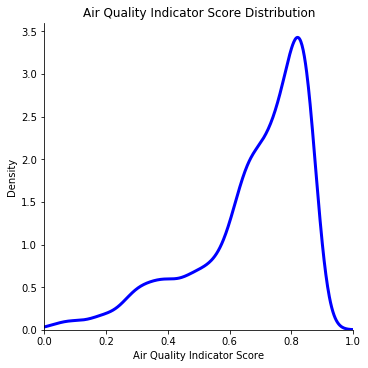

In [369]:
# Plot the distribution of the green index
fig, ax = plt.subplots(1,1, figsize=(5, 5), constrained_layout=True)

merge_all_indicators['air_quality_idx'].plot.kde(
    ax=ax,
    title="Air Quality Indicator Score Distribution",
    color="blue",
    linewidth=3
)
ax.set_xlabel("Air Quality Indicator Score")
ax.set_xlim(left=0,right=1)
ax.set_ylim(bottom=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

### Noise

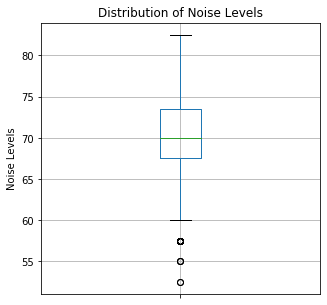

In [354]:
fig,ax = plt.subplots(1,1, figsize=(5,5))
merge_all_indicators.boxplot(ax=ax, column='mean_noise')
ax.set_title("Distribution of Noise Levels")

ax.set_xticklabels([""])
ax.set_ylabel("Noise Levels")

fig.savefig("../images/mean-noise-box-plot.png", dpi=1200, bbox_inches="tight")

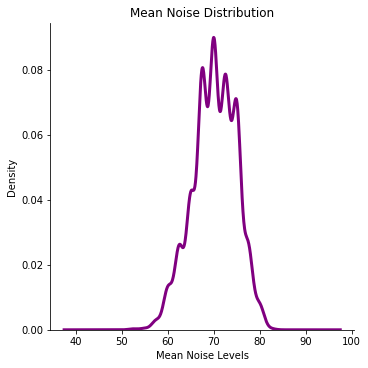

In [355]:
# Show that it's a pretty normal distribution
fig, ax = plt.subplots(1,1, figsize=(5, 5), constrained_layout=True)

merge_all_indicators['mean_noise'].plot.kde(
    ax=ax,
    title="Mean Noise Distribution",
    color="purple",
    linewidth=3
)
ax.set_xlabel("Mean Noise Levels")
ax.set_ylim(bottom=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [356]:
def normalize_noise(row):
    return (row['mean_noise'] - merge_all_indicators['mean_noise'].min()) / (merge_all_indicators['mean_noise'].max() - merge_all_indicators['mean_noise'].min())

merge_all_indicators['norm_noise'] = merge_all_indicators.apply(lambda x: normalize_noise(x), axis=1)
merge_all_indicators.head()

,id,codigo,nomoficial,alt_izqini,alt_izqfin,alt_derini,alt_derfin,nomanter,nom_mapa,tipo_c,...,norm_trees,norm_park,trees_w,park_w,green_idx,adjusted_num_buses,norm_sep_traffic,norm_buses,air_quality_idx,norm_noise
0,896,16003,"OBLIGADO RAFAEL, Av.Costanera",6182,6200,6181,6199,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,...,0.425,0.140574,0.9,0.1,0.397,25.0,0.66,0.5,0.528333,0.800000
1,1724,16003,"OBLIGADO RAFAEL, Av.Costanera",4202,4500,4201,4499,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,...,1.000,0.003109,0.9,0.1,0.900,25.0,0.66,0.5,0.720000,0.833333
2,1828,16003,"OBLIGADO RAFAEL, Av.Costanera",3452,4200,3451,4199,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,...,0.525,0.012585,0.9,0.1,0.474,25.0,0.66,0.5,0.561667,0.750000
3,1997,21059,TRONADOR,0,0,0,0,ESTOMBA Y PLAZA,TRONADOR,CALLE,...,0.425,0.000000,0.9,0.1,0.382,0.0,0.66,1.0,0.695000,0.166667
4,4846,20075,SARMIENTO AV.,2602,3100,2601,3099,None,AV. SARMIENTO,AVENIDA,...,1.000,1.000000,0.5,0.5,1.000,129.0,0.66,0.0,0.553333,0.666667


### Thermal comfort

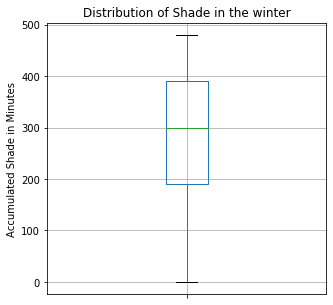

In [359]:
fig,ax = plt.subplots(1,1, figsize=(5,5))
merge_all_indicators.boxplot(ax=ax, column='shade_win')
ax.set_title("Distribution of Shade in the winter")

ax.set_xticklabels([""])
ax.set_ylabel("Accumulated Shade in Minutes")

fig.savefig("../images/winter-shade-box-plot.png", dpi=1200, bbox_inches="tight")

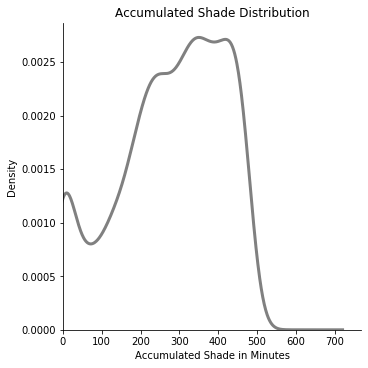

In [361]:
## It a beautiful distribution <3
fig, ax = plt.subplots(1,1, figsize=(5, 5), constrained_layout=True)

merge_all_indicators['shade_win'].plot.kde(
    ax=ax,
    title="Accumulated Shade Distribution",
    color="grey",
    linewidth=3
)
ax.set_xlabel("Accumulated Shade in Minutes")
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


In [370]:
def normalize_winter_shade(row):
    return 1 - (row['shade_win'] / merge_all_indicators['shade_win'].max())
    
merge_all_indicators['norm_shade_win'] = merge_all_indicators.apply(lambda x: normalize_winter_shade(x), axis=1)    
merge_all_indicators.head()

,id,codigo,nomoficial,alt_izqini,alt_izqfin,alt_derini,alt_derfin,nomanter,nom_mapa,tipo_c,...,norm_park,trees_w,park_w,green_idx,adjusted_num_buses,norm_sep_traffic,norm_buses,air_quality_idx,norm_noise,norm_shade_win
0,896,16003,"OBLIGADO RAFAEL, Av.Costanera",6182,6200,6181,6199,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,...,0.140574,0.9,0.1,0.397,25.0,0.66,0.5,0.549,0.800000,1.000000
1,1724,16003,"OBLIGADO RAFAEL, Av.Costanera",4202,4500,4201,4499,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,...,0.003109,0.9,0.1,0.900,25.0,0.66,0.5,0.664,0.833333,1.000000
2,1828,16003,"OBLIGADO RAFAEL, Av.Costanera",3452,4200,3451,4199,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,...,0.012585,0.9,0.1,0.474,25.0,0.66,0.5,0.569,0.750000,1.000000
3,1997,21059,TRONADOR,0,0,0,0,ESTOMBA Y PLAZA,TRONADOR,CALLE,...,0.000000,0.9,0.1,0.382,0.0,0.66,1.0,0.749,0.166667,0.529167
4,4846,20075,SARMIENTO AV.,2602,3100,2601,3099,None,AV. SARMIENTO,AVENIDA,...,1.000000,0.5,0.5,1.000,129.0,0.66,0.0,0.464,0.666667,0.833750


In [372]:
sum_heights_Q1 = merge_all_indicators['sum_height'].quantile(.25)
sum_heights_Q3 = merge_all_indicators['sum_height'].quantile(.75)
sum_heights_IQR = sum_heights_Q3 - sum_heights_Q1
tukey_upper_fence = sum_heights_Q3 + 1.5 * sum_heights_IQR
tukey_upper_fence

642.0

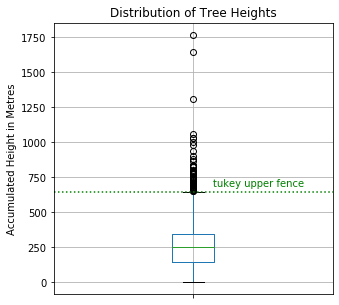

In [379]:
## Tree height as proxy for shade
fig,ax = plt.subplots(1,1, figsize=(5,5))
merge_all_indicators.boxplot(ax=ax, column='sum_height')
ax.set_title("Distribution of Tree Heights")

ax.axhline(y=642, color="green", linestyle=':')
ax.annotate("tukey upper fence",xy=(1.07,680), color="green")
ax.set_xticklabels([""])
ax.set_ylabel("Accumulated Height in Metres")

fig.savefig("../images/tree-heights-box-plot.png", dpi=1200, bbox_inches="tight")

In [375]:
merge_all_indicators.loc[merge_all_indicators['sum_height']>642].sort_values('sum_height').head()

,id,codigo,nomoficial,alt_izqini,alt_izqfin,alt_derini,alt_derfin,nomanter,nom_mapa,tipo_c,...,norm_park,trees_w,park_w,green_idx,adjusted_num_buses,norm_sep_traffic,norm_buses,air_quality_idx,norm_noise,norm_shade_win
2096,12773,2051,BELGRANO AV.,2102,2200,2101,2199,MONSERRAT,AV.BELGRANO,AVENIDA,...,0.00000,0.9,0.1,0.900,18.0,0.00,0.64,0.456,0.750000,0.175833
139,2607,7033,"GARCIA, TEODORO",1902,2000,1901,1999,ESTECO,TEODORO GARCIA,CALLE,...,0.00000,0.9,0.1,0.900,75.0,0.66,0.00,0.464,0.583333,0.089792
1265,4198,7093,GUATEMALA,6002,6100,6001,6099,None,GUATEMALA,CALLE,...,0.00000,0.9,0.1,0.900,0.0,0.66,1.00,0.864,0.500000,0.575000
834,14852,1149,AZOPARDO,1102,1200,1101,1199,None,AZOPARDO,CALLE,...,0.00000,0.9,0.1,0.810,14.0,0.66,0.72,0.732,0.750000,0.594167
363,7457,1008,"ACUÑA DE FIGUEROA, FRANCISCO",1602,1700,1601,1699,ALMAGRO,FRANCISCO ACUÑA DE FIGUEROA,CALLE,...,0.17017,0.9,0.1,0.917,3.0,0.66,0.94,0.840,0.500000,0.384375


In [381]:
def normalize_tree_height(row):
    if row['sum_height'] > 640:
        return 1
    return row['sum_height'] / 640

merge_all_indicators['norm_sum_height'] = merge_all_indicators.apply(lambda x: normalize_tree_height(x), axis=1)
merge_all_indicators.head()

,id,codigo,nomoficial,alt_izqini,alt_izqfin,alt_derini,alt_derfin,nomanter,nom_mapa,tipo_c,...,trees_w,park_w,green_idx,adjusted_num_buses,norm_sep_traffic,norm_buses,air_quality_idx,norm_noise,norm_shade_win,norm_sum_height
0,896,16003,"OBLIGADO RAFAEL, Av.Costanera",6182,6200,6181,6199,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,...,0.9,0.1,0.397,25.0,0.66,0.5,0.549,0.800000,1.000000,0.253125
1,1724,16003,"OBLIGADO RAFAEL, Av.Costanera",4202,4500,4201,4499,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,...,0.9,0.1,0.900,25.0,0.66,0.5,0.664,0.833333,1.000000,0.731250
2,1828,16003,"OBLIGADO RAFAEL, Av.Costanera",3452,4200,3451,4199,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,...,0.9,0.1,0.474,25.0,0.66,0.5,0.569,0.750000,1.000000,0.357812
3,1997,21059,TRONADOR,0,0,0,0,ESTOMBA Y PLAZA,TRONADOR,CALLE,...,0.9,0.1,0.382,0.0,0.66,1.0,0.749,0.166667,0.529167,0.223438
4,4846,20075,SARMIENTO AV.,2602,3100,2601,3099,None,AV. SARMIENTO,AVENIDA,...,0.5,0.5,1.000,129.0,0.66,0.0,0.464,0.666667,0.833750,0.560937


In [382]:
# Aggregate thermal comfort indicator with arithmetic mean
def aggregate_thermal(row):
    return (row['norm_shade_win'] + row['norm_sum_height']) / 2

merge_all_indicators['thermal_idx'] = merge_all_indicators.apply(lambda x: aggregate_thermal(x), axis=1)
merge_all_indicators.head()

,id,codigo,nomoficial,alt_izqini,alt_izqfin,alt_derini,alt_derfin,nomanter,nom_mapa,tipo_c,...,park_w,green_idx,adjusted_num_buses,norm_sep_traffic,norm_buses,air_quality_idx,norm_noise,norm_shade_win,norm_sum_height,thermal_idx
0,896,16003,"OBLIGADO RAFAEL, Av.Costanera",6182,6200,6181,6199,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,...,0.1,0.397,25.0,0.66,0.5,0.549,0.800000,1.000000,0.253125,0.626563
1,1724,16003,"OBLIGADO RAFAEL, Av.Costanera",4202,4500,4201,4499,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,...,0.1,0.900,25.0,0.66,0.5,0.664,0.833333,1.000000,0.731250,0.865625
2,1828,16003,"OBLIGADO RAFAEL, Av.Costanera",3452,4200,3451,4199,"COSTANERA NORTE, Av.",AV.COSTANERA RAFAEL OBLIGADO,AVENIDA,...,0.1,0.474,25.0,0.66,0.5,0.569,0.750000,1.000000,0.357812,0.678906
3,1997,21059,TRONADOR,0,0,0,0,ESTOMBA Y PLAZA,TRONADOR,CALLE,...,0.1,0.382,0.0,0.66,1.0,0.749,0.166667,0.529167,0.223438,0.376302
4,4846,20075,SARMIENTO AV.,2602,3100,2601,3099,None,AV. SARMIENTO,AVENIDA,...,0.5,1.000,129.0,0.66,0.0,0.464,0.666667,0.833750,0.560937,0.697344


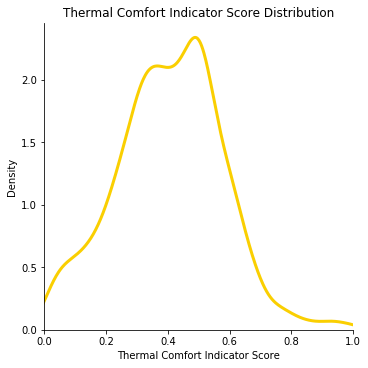

In [385]:
# Plot the distribution of the themal indicator
fig, ax = plt.subplots(1,1, figsize=(5, 5), constrained_layout=True)

merge_all_indicators['thermal_idx'].plot.kde(
    ax=ax,
    title="Thermal Comfort Indicator Score Distribution",
    color="#facf01",
    linewidth=3
)
ax.set_xlabel("Thermal Comfort Indicator Score")
ax.set_xlim(left=0,right=1)
ax.set_ylim(bottom=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

## Environmental Index!!! Finally!

In [392]:
def aggregate_all_indicators(row):
    # Add 0.1 to account for zeros in geometric mean and substract at the end
    green_ind = row['green_idx'] + 0.1
    air_ind = row['air_quality_idx'] + 0.1
    noise_ind = row['norm_noise'] + 0.1
    thermal_ind = row['thermal_idx'] + 0.1
    return stats.gmean([green_ind,air_ind,noise_ind,thermal_ind]) - 0.1

merge_all_indicators['environmental_idx'] = merge_all_indicators.apply(lambda x: aggregate_all_indicators(x), axis=1)
merge_all_indicators.sort_values('environmental_idx', ascending=False).head()

,id,codigo,nomoficial,alt_izqini,alt_izqfin,alt_derini,alt_derfin,nomanter,nom_mapa,tipo_c,...,green_idx,adjusted_num_buses,norm_sep_traffic,norm_buses,air_quality_idx,norm_noise,norm_shade_win,norm_sum_height,thermal_idx,environmental_idx
1238,29085,6025,"FIGUEROA ALCORTA, PRES. AV.",6902,7070,6901,7069,"CENTENARIO, Av.",AV.PRES. FIGUEROA ALCORTA,AVENIDA,...,0.993,7.0,0.66,0.86,0.808,0.750000,1.000000,1.000000,1.000000,0.881475
2824,871,6025,"FIGUEROA ALCORTA, PRES. AV.",6702,6900,6701,6899,"CENTENARIO, Av.",AV.PRES. FIGUEROA ALCORTA,AVENIDA,...,0.995,7.0,0.66,0.86,0.808,0.750000,0.992917,0.957812,0.975365,0.876380
248,5314,6025,"FIGUEROA ALCORTA, PRES. AV.",2302,2800,2301,2799,"CENTENARIO, Av.",AV.PRES. FIGUEROA ALCORTA,AVENIDA,...,1.000,5.0,0.66,0.90,0.824,0.750000,0.995417,0.817187,0.906302,0.865613
107,2151,6025,"FIGUEROA ALCORTA, PRES. AV.",5402,5692,5401,5691,"CENTENARIO, Av.",AV.PRES. FIGUEROA ALCORTA,AVENIDA,...,0.965,22.0,0.66,0.56,0.688,0.833333,1.000000,1.000000,1.000000,0.863444
1361,28513,3054,"CANTILO, Int.",0,0,0,0,None,INT. CANTILO,CALLE,...,0.929,22.0,0.66,0.56,0.688,0.916667,1.000000,0.889062,0.944531,0.863297


## Group cycle segments into facilities
We'll consider a cycle facily the group of segments with the same street name within a neighbourhood

In [19]:
ciclovias_df.groupby('BARRIO')['BARRIO'].count()

BARRIO
AGRONOMIA             41
ALMAGRO              121
BALVANERA            145
BARRACAS              78
BELGRANO             158
BOCA                  63
BOEDO                 73
CABALLITO            168
CHACARITA             40
COGHLAN               29
COLEGIALES            44
CONSTITUCION          51
FLORES                70
FLORESTA              20
LINIERS               30
MATADEROS             37
MONSERRAT             78
MONTE CASTRO          61
NUEVA POMPEYA         32
NUÑEZ                 96
PALERMO              260
PARQUE AVELLANEDA     33
PARQUE CHACABUCO      81
PARQUE CHAS           23
PARQUE PATRICIOS      58
PATERNAL              17
PUERTO MADERO          8
RECOLETA              97
RETIRO                67
SAAVEDRA             123
SAN CRISTOBAL         51
SAN NICOLAS           96
SAN TELMO             19
VERSALLES              7
VILLA CRESPO          95
VILLA DEL PARQUE      30
VILLA DEVOTO           5
VILLA GRAL. MITRE     41
VILLA LUGANO          11
VILLA LURO        

In [185]:
ciclovias_by_calle_and_barrio = ciclovias_df.groupby(['nom_mapa','BARRIO'])['geometry'].agg(lambda x: shapely.ops.linemerge(x.values)).reset_index()

In [186]:
ciclovias_by_calle_and_barrio.head()

,nom_mapa,BARRIO,geometry
0,11 DE SEPTIEMBRE DE 1888,BELGRANO,(LINESTRING (100899.9781146892 108140.30062243...
1,11 DE SEPTIEMBRE DE 1888,PALERMO,LINESTRING (101794.4323969691 106861.389740327...
2,14 DE JULIO,PATERNAL,LINESTRING (99413.21298149042 104137.617320728...
3,15 DE NOVIEMBRE DE 1889,PARQUE PATRICIOS,LINESTRING (106601.9751960236 99729.7997055884...
4,ACHAVAL,CABALLITO,LINESTRING (101328.8519519888 100034.894154154...
